In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
hidden_dim = 128
original_dim = 784
eta = 1e-3
momentum =8e-1 
batch_size = 256
max_epochs = 10

In [3]:
(X_train, _),(X_test, _) = tf.keras.datasets.mnist.load_data()

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

X_train = np.reshape(X_train, (X_train.shape[0], original_dim))
X_test = np.reshape(X_test, (X_test.shape[0], original_dim))

noise = np.random.normal(loc = 0.5, scale = 0.5, size = X_train.shape).astype(np.float32)
X_train_noisy = X_train + noise
noise = np.random.normal(loc = 0.5, scale = 0.5, size = X_test.shape).astype(np.float32)
X_test_noisy = X_test + noise

training_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
training_dataset_noisy = tf.data.Dataset.from_tensor_slices(X_train_noisy).batch(batch_size)

In [4]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units = hidden_dim,
                activation = 'relu', activity_regularizer = tf.keras.regularizers.l1(10e-5))
   
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

In [5]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = tf.keras.layers.Dense(units=original_dim,
            activation='relu')
    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation

In [6]:
class Autoencoder(tf.keras.Model):
    def __init__(self, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim)
        self.decoder = Decoder(original_dim)
        
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [7]:
model = Autoencoder(hidden_dim, original_dim)
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adam(learning_rate = eta))

In [8]:
history = model.fit(X_train_noisy,
                    X_train,
                    validation_data = (X_test_noisy, X_test),
                    epochs = max_epochs,
                    batch_size = batch_size)

Epoch 1/10
235/235 [==============================] - 49s 207ms/step - loss: 0.0480 - val_loss: 0.0316
Epoch 2/10
235/235 [==============================] - 58s 246ms/step - loss: 0.0291 - val_loss: 0.0269
Epoch 3/10
235/235 [==============================] - 41s 175ms/step - loss: 0.0261 - val_loss: 0.0251
Epoch 4/10
235/235 [==============================] - 44s 189ms/step - loss: 0.0246 - val_loss: 0.0242
Epoch 5/10
235/235 [==============================] - 38s 162ms/step - loss: 0.0239 - val_loss: 0.0236
Epoch 6/10
235/235 [==============================] - 39s 166ms/step - loss: 0.0235 - val_loss: 0.0233
Epoch 7/10
235/235 [==============================] - 39s 165ms/step - loss: 0.0232 - val_loss: 0.0231
Epoch 8/10
235/235 [==============================] - 47s 200ms/step - loss: 0.0229 - val_loss: 0.0228
Epoch 9/10
235/235 [==============================] - 39s 167ms/step - loss: 0.0227 - val_loss: 0.0229
Epoch 10/10
235/235 [==============================] - 39s 164ms/step - l

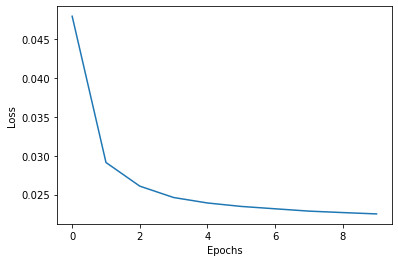

In [9]:
plt.plot(range(max_epochs), history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

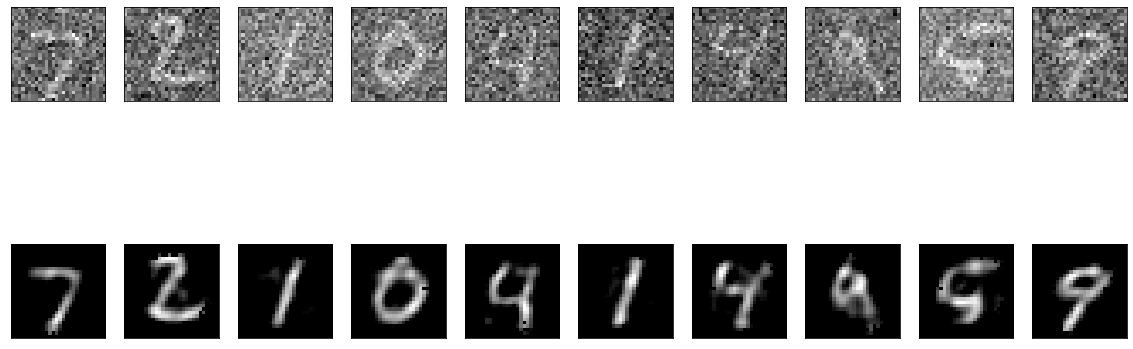

In [10]:
reconstructed = model(X_test_noisy).numpy()
number = 10
plt.figure(figsize = (20, 8))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(X_test_noisy[index].reshape(28,28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(reconstructed[index].reshape(28,28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
autoencoder = Autoencoder(hidden_dim, original_dim)
opt = tf.keras.optimizers.Adam(learning_rate = eta)

def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

In [12]:
def train(autoencoder, noisy, original, opt):
    with tf.GradientTape() as tape:
        reconstructed = autoencoder(noisy)
        rec_loss = loss(reconstructed, original)
    gradients = tape.gradient(rec_loss, autoencoder.trainable_weights)
    gradients_variables = zip(gradients, autoencoder.trainable_weights)
    opt.apply_gradients(gradients_variables)
    return rec_loss

In [13]:
def train_loop(autoencoder, opt, noisy, original, epochs):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, (input_features, output_features) in enumerate(zip(noisy, original)):
            rec_loss = train(autoencoder, input_features, output_features, opt)
            epoch_loss += rec_loss
        epoch_loss /= step
        autoencoder.loss.append(epoch_loss)
        print("Epoch: %d, Loss: %.6f" % (epoch + 1, epoch_loss.numpy()))

In [14]:
train_loop(autoencoder, opt, training_dataset_noisy, training_dataset, max_epochs)

Epoch: 1, Loss: 0.047296
Epoch: 2, Loss: 0.029195
Epoch: 3, Loss: 0.026662
Epoch: 4, Loss: 0.025885
Epoch: 5, Loss: 0.025414
Epoch: 6, Loss: 0.024987
Epoch: 7, Loss: 0.024642
Epoch: 8, Loss: 0.024219
Epoch: 9, Loss: 0.023829
Epoch: 10, Loss: 0.023364


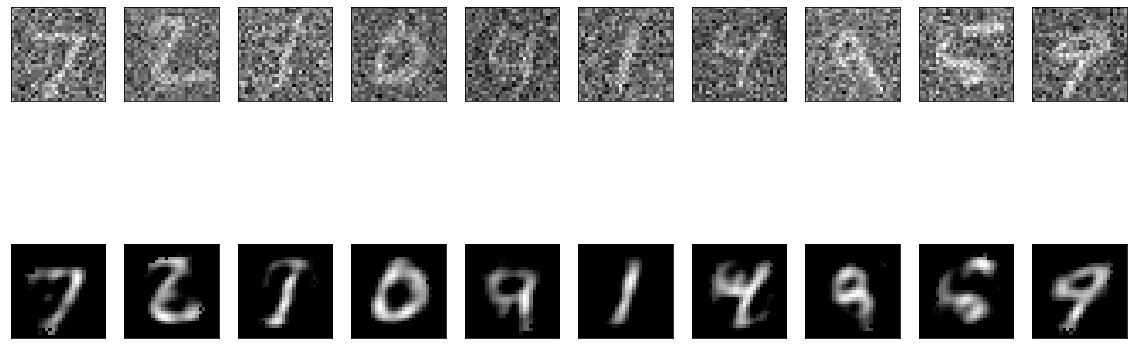

In [11]:
reconstructed = autoencoder(X_test_noisy).numpy()
number = 10
plt.figure(figsize = (20, 8))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(X_test_noisy[index].reshape(28,28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(reconstructed[index].reshape(28,28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()